In [3]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pandas

In [5]:
pip install sentence-transformers


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install tensorflow


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 166.5 MB/s  0:00:020:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 232.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 254.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 244.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 181.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 274.3 MB/s  0:00:00
  Attempting uninstall: protobuf━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/16 [libclang]
    Found existing installation: protobuf 4.23.4━━━━━━━━━━━━━━  1/16 [libclang]
    Uninstalling protobuf-4.23.4:m━━━━━━━━━━━━━━━━━━━━━━━━━━━  5/16 [protobuf]
      Successfully uninstalled protobuf-4.23.4━━━━━━━━━━━━━━━━  5/16 [protobuf]
  Attempting uninstall: tensorboard0m╺━━━━━━━━━━━━━━ 10/16 [google_pasta]
    Found existing installation: tensorboard 2.15.1━━━━━━━━━━━ 10/16 [google_pasta]
    Uninstalling tensorboard-2.15.1:0m╺━━━━━━━━━━━━

In [6]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [1]:
import pandas as pd



In [2]:
df=pd.read_csv("final_category.csv")

In [3]:
df.shape

(75000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sample_id                  75000 non-null  int64  
 1   catalog_content            75000 non-null  object 
 2   unit                       75000 non-null  object 
 3   unit_qty                   75000 non-null  float64
 4   pack_count                 75000 non-null  int64  
 5   total_qty                  75000 non-null  float64
 6   num_bullet_points          75000 non-null  float64
 7   num_product_desc           75000 non-null  float64
 8   total_chars_bullet_points  75000 non-null  float64
 9   total_chars_product_desc   75000 non-null  float64
 10  avg_bullet_point_len       75000 non-null  float64
 11  price                      75000 non-null  float64
 12  brand_name                 75000 non-null  object 
 13  category                   75000 non-null  obj

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib

numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='Lajavaness/bilingual-embedding-large', batch_size=128, device='cuda'):
    model = SentenceTransformer(model_name, device=device,trust_remote_code=True)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline.pkl', model_name='Lajavaness/bilingual-embedding-large'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        y = df[target_col]
        preprocessor.fit(X_non_text, y)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


X_train = process_catalog_df(df, target_col='price', test=False)
# X_test = process_catalog_df(test_data, target_col='price', test=True)



Non-text pipeline saved to process_pipeline.pkl


Batches:   0%|          | 0/586 [00:00<?, ?it/s]

In [6]:
Y_train=df["price"]

In [7]:
print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)


X train shape: (75000, 1035)
Y train shape: (75000,)


In [8]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
Y_train = np.nan_to_num(Y_train, nan=0.0, posinf=0.0, neginf=0.0)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.saving import register_keras_serializable

@tf.keras.saving.register_keras_serializable()
def smape_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = tf.abs(y_true - y_pred)
    denominator = tf.maximum((tf.abs(y_true) + tf.abs(y_pred)) / 2.0, 1e-3)
    smape = numerator / denominator
    smape = tf.where(tf.math.is_finite(smape), smape, tf.zeros_like(smape))
    return tf.reduce_mean(smape)


def build_optimized_mlp(input_dim):
    model = Sequential([
        Dense(512, input_dim=input_dim),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(256),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.25),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.15),

        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss=smape_loss, metrics=['mae'])
    return model


callbacks = [
    ModelCheckpoint('best_mlp_smape_model.h5', monitor='val_loss', save_best_only=True, verbose=1),

]

# ✅ Build and train
input_dim = X_train.shape[1]
model = build_optimized_mlp(input_dim)

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# ✅ Evaluate
best_model = tf.keras.models.load_model('best_mlp_smape_model.h5', custom_objects={'smape_loss': smape_loss})
# loss, mae = best_model.evaluate(X_test, Y_test, verbose=0)
# print(f"✅ Best Model SMAPE: {loss:.4f}, MAE: {mae:.4f}")


2025-10-13 05:31:12.352995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1760333474.993754   26159 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3

Epoch 1/100


2025-10-13 05:31:18.638924: I external/local_xla/xla/service/service.cc:163] XLA service 0x7cc874010e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-13 05:31:18.638953: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-10-13 05:31:18.740574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-13 05:31:19.089033: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-13 05:31:19.338424: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:19.338456: I external/loca

 99/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1070 - mae: 19.4928

I0000 00:00:1760333484.840791   62509 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


442/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7182 - mae: 14.6435

2025-10-13 05:31:25.995586: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:25.995614: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:25.995624: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:25.995634: I external/l

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7072 - mae: 14.4761

2025-10-13 05:31:33.056767: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:33.056801: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:33.056815: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 05:31:34.262372: I external/l


Epoch 1: val_loss improved from None to 0.46994, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.5241 - mae: 11.6782 - val_loss: 0.4699 - val_mae: 10.3597
Epoch 2/100
443/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4399 - mae: 10.0880
Epoch 2: val_loss did not improve from 0.46994
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4308 - mae: 9.8956 - val_loss: 0.5211 - val_mae: 11.0831
Epoch 3/100
448/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4185 - mae: 9.5157
Epoch 3: val_loss improved from 0.46994 to 0.45123, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4177 - mae: 9.5479 - val_loss: 0.4512 - val_mae: 9.5299
Epoch 4/100
449/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4104 - mae: 9.3894
Epoch 4: val_loss improved from 0.45123 to 0.44823, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4122 - mae: 9.4375 - val_loss: 0.4482 - val_mae: 9.8522
Epoch 5/100
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4018 - mae: 9.2177
Epoch 5: val_loss improved from 0.44823 to 0.43298, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4042 - mae: 9.2778 - val_loss: 0.4330 - val_mae: 9.5878
Epoch 6/100
443/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4009 - mae: 9.3194
Epoch 6: val_loss improved from 0.43298 to 0.41588, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3993 - mae: 9.1583 - val_loss: 0.4159 - val_mae: 9.2114
Epoch 7/100
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3937 - mae: 9.0671
Epoch 7: val_loss did not improve from 0.41588
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3959 - mae: 9.0926 - val_loss: 0.4662 - val_mae: 9.5091
Epoch 8/100
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3903 - mae: 9.1187
Epoch 8: val_loss did not improve from 0.41588
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3908 - mae: 9.0005 - val_loss: 0.4559 - val_mae: 9.5471
Epoch 9/100
440/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3866 - mae: 9.0390
Epoch 9: val_loss improved from 0.41588 to 0.37461, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3875 - mae: 8.9306 - val_loss: 0.3746 - val_mae: 8.2367
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3856 - mae: 8.9312
Epoch 10: val_loss did not improve from 0.37461
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3859 - mae: 8.8639 - val_loss: 0.4239 - val_mae: 8.7368
Epoch 11/100
455/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3842 - mae: 8.8687
Epoch 11: val_loss did not improve from 0.37461
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3811 - mae: 8.7888 - val_loss: 0.4297 - val_mae: 9.9798
Epoch 12/100
439/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3795 - mae: 8.8147
Epoch 12: val_loss did not improve from 0.37461
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3784 - mae: 8.7034 - val_loss: 0.4398 - val_mae: 9.5462
Epoch 13/100
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3792 - mae: 8.7204
Epoch 13: val_loss improved from 0.37461 to 0.36233, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3775 - mae: 8.7438 - val_loss: 0.3623 - val_mae: 9.1035
Epoch 14/100
449/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3720 - mae: 8.9173
Epoch 14: val_loss did not improve from 0.36233
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3737 - mae: 8.6587 - val_loss: 0.3631 - val_mae: 7.9246
Epoch 15/100
445/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3691 - mae: 8.4836
Epoch 15: val_loss did not improve from 0.36233
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3726 - mae: 8.6356 - val_loss: 0.4303 - val_mae: 10.3676
Epoch 16/100
448/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3677 - mae: 8.6205
Epoch 16: val_loss did not improve from 0.36233
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3671 - mae: 8.5191 - val_loss: 0.3959 - val_mae: 9.0844
Epoch 17/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3651 - mae: 8.5536
Epoch 17: val_loss did not improve from 0.36233
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3511 - mae: 8.1706 - val_loss: 0.3622 - val_mae: 8.3775
Epoch 25/100
445/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3518 - mae: 8.1926
Epoch 25: val_loss improved from 0.36218 to 0.35335, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3506 - mae: 8.1584 - val_loss: 0.3534 - val_mae: 7.9639
Epoch 26/100
452/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3477 - mae: 8.1121
Epoch 26: val_loss did not improve from 0.35335
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3490 - mae: 8.1446 - val_loss: 0.4176 - val_mae: 9.1799
Epoch 27/100
449/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3475 - mae: 8.0402
Epoch 27: val_loss did not improve from 0.35335
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3479 - mae: 8.1021 - val_loss: 0.3643 - val_mae: 7.9130
Epoch 28/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3421 - mae: 7.9686
Epoch 28: val_loss did not improve from 0.35335
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3451 - mae: 8.0451 - val_loss: 0.3636 - val_mae: 8.5384
Epoch 29/100
448/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3435 - mae: 8.0776
Epoch 29: val_loss did not improve from 0.35335
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3283 - mae: 7.7107 - val_loss: 0.3401 - val_mae: 7.6864
Epoch 41/100
441/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3263 - mae: 7.7928
Epoch 41: val_loss did not improve from 0.34006
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3256 - mae: 7.6419 - val_loss: 0.3612 - val_mae: 8.3467
Epoch 42/100
442/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3279 - mae: 7.6589
Epoch 42: val_loss did not improve from 0.34006
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3288 - mae: 7.6844 - val_loss: 0.3936 - val_mae: 8.7969
Epoch 43/100
437/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3242 - mae: 7.6504
Epoch 43: val_loss did not improve from 0.34006
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3263 - mae: 7.6690 - val_loss: 0.3695 - val_mae: 8.8295
Epoch 44/100
448/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3258 - mae: 7.4034
Epoch 44: val_loss improved from 0.34006 to 0.33960, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3240 - mae: 7.5951 - val_loss: 0.3396 - val_mae: 7.6309
Epoch 45/100
439/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3192 - mae: 7.4431
Epoch 45: val_loss did not improve from 0.33960
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3228 - mae: 7.5423 - val_loss: 0.4565 - val_mae: 9.9285
Epoch 46/100
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3168 - mae: 7.4244
Epoch 46: val_loss did not improve from 0.33960
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3207 - mae: 7.5279 - val_loss: 0.3864 - val_mae: 8.8840
Epoch 47/100
451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3219 - mae: 7.5152
Epoch 47: val_loss did not improve from 0.33960
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3210 - mae: 7.5810 - val_loss: 0.3595 - val_mae: 7.8599
Epoch 48/100
451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3177 - mae: 7.4474
Epoch 48: val_loss did not improve from 0.33960
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3128 - mae: 7.4107 - val_loss: 0.3382 - val_mae: 7.5778
Epoch 55/100
442/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3153 - mae: 7.5779
Epoch 55: val_loss did not improve from 0.33818
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3130 - mae: 7.3958 - val_loss: 0.3896 - val_mae: 8.5999
Epoch 56/100
439/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3117 - mae: 7.3338
Epoch 56: val_loss did not improve from 0.33818
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3125 - mae: 7.3737 - val_loss: 0.3546 - val_mae: 7.7108
Epoch 57/100
445/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3105 - mae: 7.3146
Epoch 57: val_loss did not improve from 0.33818
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3120 - mae: 7.3769 - val_loss: 0.3452 - val_mae: 8.5496
Epoch 58/100
445/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3106 - mae: 7.3063
Epoch 58: val_loss did not improve from 0.33818
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3104 - mae: 7.3236 - val_loss: 0.3368 - val_mae: 7.6337
Epoch 61/100
442/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3060 - mae: 7.2849
Epoch 61: val_loss did not improve from 0.33683
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3072 - mae: 7.2425 - val_loss: 0.3459 - val_mae: 7.8756
Epoch 62/100
447/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3072 - mae: 7.2472
Epoch 62: val_loss did not improve from 0.33683
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3067 - mae: 7.2765 - val_loss: 0.3526 - val_mae: 7.7508
Epoch 63/100
447/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3057 - mae: 7.2615
Epoch 63: val_loss did not improve from 0.33683
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3072 - mae: 7.2914 - val_loss: 0.3580 - val_mae: 8.3656
Epoch 64/100
447/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3049 - mae: 7.1567
Epoch 64: val_loss did not improve from 0.33683
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2866 - mae: 6.8562 - val_loss: 0.3325 - val_mae: 7.3588
Epoch 98/100
452/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2814 - mae: 6.7697
Epoch 98: val_loss did not improve from 0.33250
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2847 - mae: 6.8677 - val_loss: 0.3661 - val_mae: 8.4577
Epoch 99/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2814 - mae: 6.7111
Epoch 99: val_loss did not improve from 0.33250
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2843 - mae: 6.7887 - val_loss: 0.3691 - val_mae: 7.9418
Epoch 100/100
452/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2871 - mae: 7.1591
Epoch 100: val_loss did not improve from 0.33250
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2857 - mae: 6.8176 - val_loss: 0.3401 - val_mae: 7.7368


In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation metrics from a Keras model history.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    metric_keys = [k for k in history.history.keys() if 'mae' in k.lower()]
    if metric_keys:
        plt.subplot(1, 2, 2)
        plt.plot(history.history[metric_keys[0]], label='Train MAE', linewidth=2)
        val_metric = [k for k in metric_keys if k.startswith('val_')]
        if val_metric:
            plt.plot(history.history[val_metric[0]], label='Validation MAE', linewidth=2, linestyle='--')
        plt.title('Model MAE Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


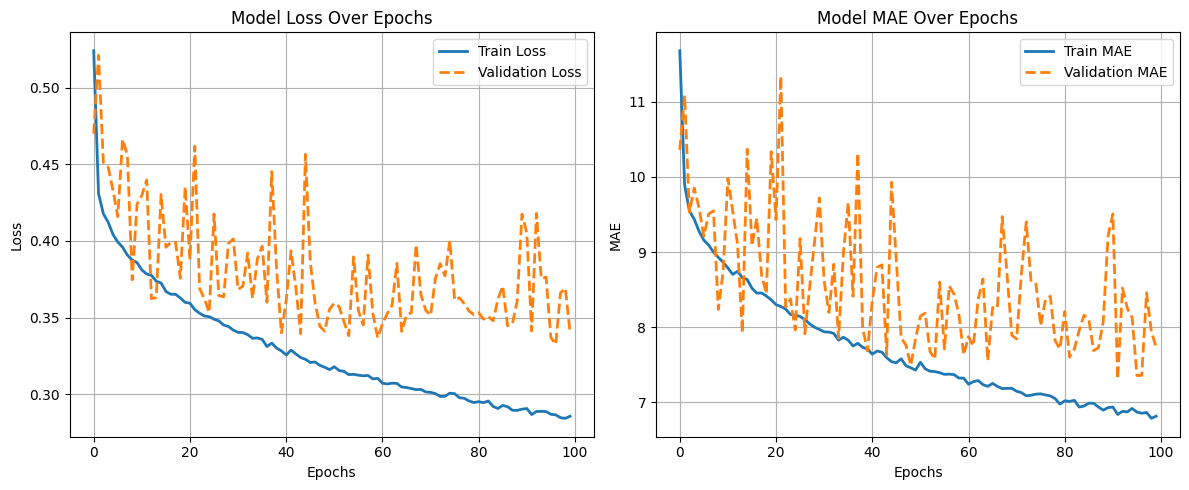

In [13]:
plot_training_history(history)

In [2]:
pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib
test_df=pd.read_csv("final_test_with_category.csv")


numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='Lajavaness/bilingual-embedding-large', batch_size=256, device='cuda'):
    model = SentenceTransformer(model_name, device=device,trust_remote_code=True)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline.pkl', model_name='Lajavaness/bilingual-embedding-large'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        y = df[target_col]
        preprocessor.fit(X_non_text, y)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


# X_train = process_catalog_df(df, target_col='price', test=False)
# X_test = process_catalog_df(test_data, target_col='price', test=True)


X_test = process_catalog_df(test_df, target_col='price', test=True)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)




Non-text pipeline loaded from process_pipeline.pkl


Batches:   0%|          | 0/293 [00:00<?, ?it/s]

In [4]:
X_test.shape

(75000, 1035)

In [6]:
from tensorflow.keras.saving import register_keras_serializable
import tensorflow as tf
@tf.keras.saving.register_keras_serializable()
def smape_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = tf.abs(y_true - y_pred)
    denominator = tf.maximum((tf.abs(y_true) + tf.abs(y_pred)) / 2.0, 1e-3)
    smape = numerator / denominator
    smape = tf.where(tf.math.is_finite(smape), smape, tf.zeros_like(smape))
    return tf.reduce_mean(smape)



In [7]:
from tensorflow.keras.models import load_model
best_model=load_model("./best_mlp_smape_model.h5",custom_objects={'smape_loss': smape_loss})


I0000 00:00:1760342672.870154    4183 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28706 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [8]:
y_pred=best_model.predict(X_test)
print(np.isnan(y_pred).sum())
test_df["sample_id"].values
pd.DataFrame(y_pred)
test_out=pd.DataFrame({"sample_id":test_df["sample_id"].values,"price":y_pred.flatten()})
test_out.isnull().sum()
test_out.to_csv("test_out.csv",index=False)

2025-10-13 08:04:43.750409: I external/local_xla/xla/service/service.cc:163] XLA service 0x78166c0044f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-13 08:04:43.750429: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-10-13 08:04:43.799479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-13 08:04:43.877692: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-13 08:04:43.915630: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 08:04:43.915669: I external/loca

 201/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step

I0000 00:00:1760342686.496340   35442 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2275/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step

2025-10-13 08:04:48.375426: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 08:04:48.375461: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 08:04:48.375470: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-13 08:04:49.340637: I external/l

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
0


In [9]:
test_out

,sample_id,price
0,100179,9.251225
1,245611,10.391413
2,146263,9.214400
3,95658,2.779847
4,36806,18.055164
...,...,...
74995,93616,2.183774
74996,249434,17.402323
74997,162217,1.943338
74998,230487,13.952469
